# Backtesting without refitting
Conda environment: `time-series`  
12 May 2024

In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

In [29]:
# Custom metric
def custom_metric(y_true, y_pred):
    """
    Calculate the MAPE
    """
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

## 1) Input data

In [3]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data.head()

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.3798,0.9588,1.1660
1,1992-05-01,0.3618,0.9520,1.1179
2,1992-06-01,0.4105,0.9530,1.0679
3,1992-07-01,0.4834,0.9581,1.0974
4,1992-08-01,0.4755,0.9564,1.1222


In [4]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.3798,0.9588,1.1660
1992-05-01,0.3618,0.9520,1.1179
1992-06-01,0.4105,0.9530,1.0679
1992-07-01,0.4834,0.9581,1.0974
1992-08-01,0.4755,0.9564,1.1222


In [5]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


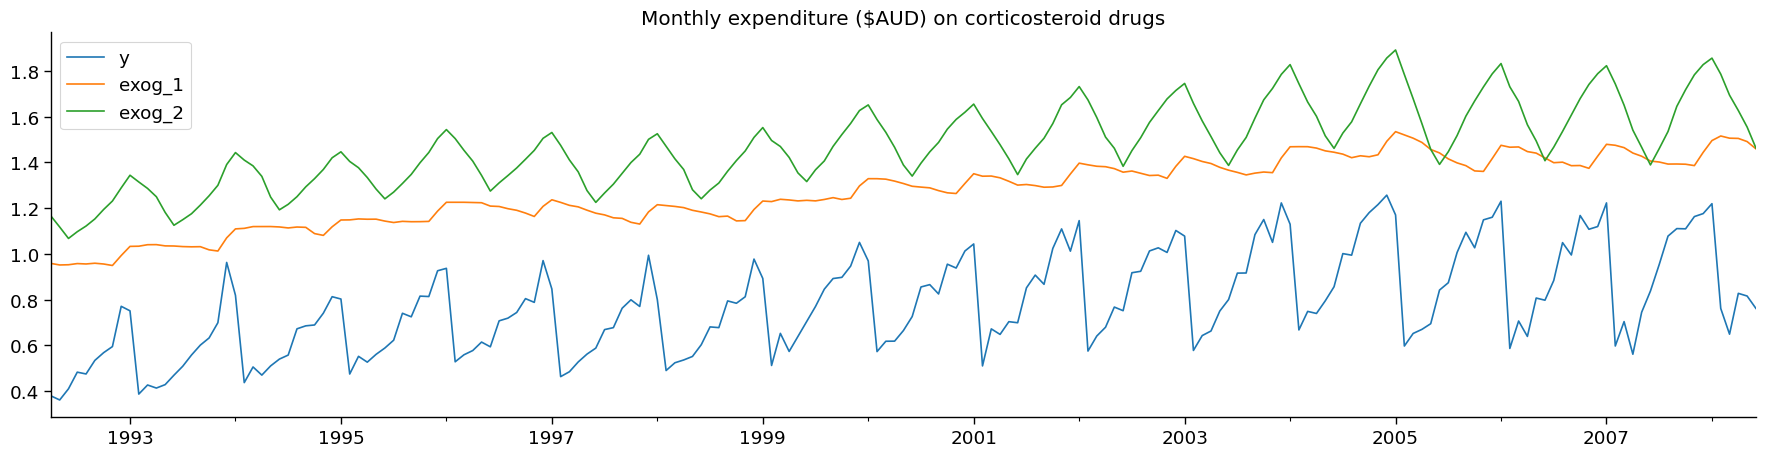

In [8]:
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")

plt.xlabel("")
plt.show()

## 2) Backtesting without refitting

In [16]:
# Create forecaster
model = RandomForestRegressor(random_state=123)
lags = [1, 2, 3, 12]

forecaster = ForecasterAutoreg(
    regressor=model,
    lags=lags,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting
initial_train_size

174

In [17]:
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    steps=steps,
    metric="mean_squared_error",
    refit=False,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



100%|██████████| 3/3 [00:00<00:00, 19.34it/s]

Backtest metric (MSE): 0.006185906718718503


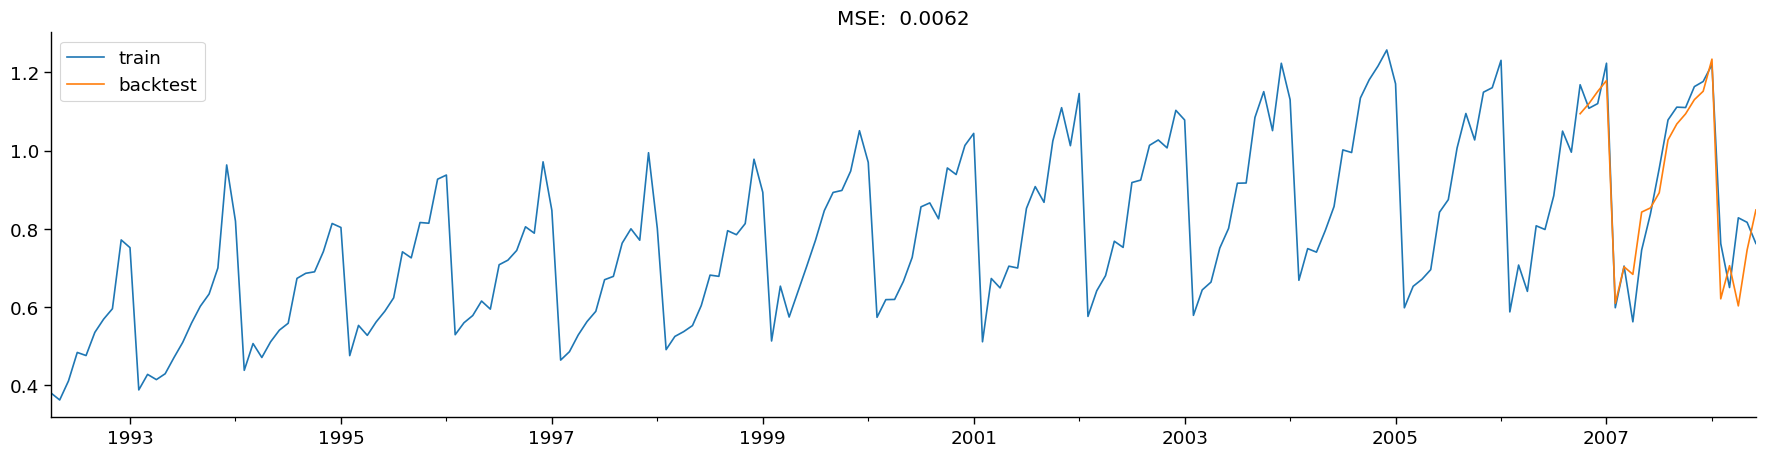

In [28]:
error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)


fig, ax = plt.subplots()

data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend()

plt.title(f"MSE: {error_mse: .4f}")
plt.xlabel("")
plt.show()

## 3) Custom metrics
In this case, MAPE is implemented but we are going to use it as an example.

In [30]:
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    fixed_train_size=True,
    steps=steps,
    metric=["mean_absolute_percentage_error", custom_metric],
    refit=False,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metrics: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



100%|██████████| 3/3 [00:00<00:00, 24.14it/s]

Backtest metrics: [0.07118520414780306, 7.118520414780306]


## 4) Multiple indepdent time series

In [34]:
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [35]:
# Data preprocessing
selected_store = 2
selected_items = data.item.unique()  # All items


# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

data.head()

,date,store,item,sales
1826,2013-01-01,2,1,12
1827,2013-01-02,2,1,16
1828,2013-01-03,2,1,16
1829,2013-01-04,2,1,20
1830,2013-01-05,2,1,16


In [36]:
# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")
data

item,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22.0000,101.0000,90.0000,44.0000,72.0000,50.0000,56.0000,25.0000,78.0000,93.0000,38.0000,110.0000,49.0000,36.0000,20.0000,56.0000,59.0000,37.0000,91.0000,78.0000,33.0000,56.0000,33.0000,67.0000


In [38]:
# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data

,item_item_1,item_item_2,item_item_3,item_item_4,item_item_5,item_item_6,item_item_7,item_item_8,item_item_9,item_item_10,item_item_11,item_item_12,item_item_13,item_item_14,item_item_15,item_item_16,item_item_17,item_item_18,item_item_19,item_item_20,item_item_21,item_item_22,item_item_23,item_item_24,item_item_25,item_item_26,item_item_27,item_item_28,item_item_29,item_item_30,item_item_31,item_item_32,item_item_33,item_item_34,item_item_35,item_item_36,item_item_37,item_item_38,item_item_39,item_item_40,item_item_41,item_item_42,item_item_43,item_item_44,item_item_45,item_item_46,item_item_47,item_item_48,item_item_49,item_item_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.0000,74.0000,88.0000,72.0000,22

In [39]:
# Check if any missing values introduced
data.isnull().sum().any()

False

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_45505/3818824711.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


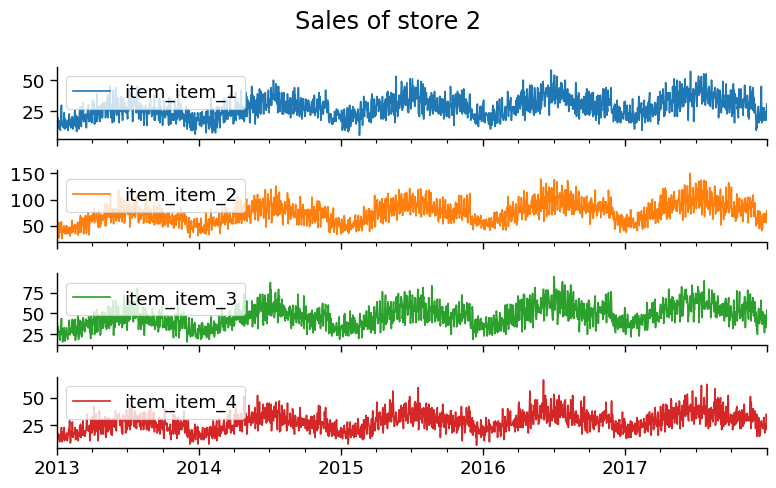

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)

plt.xlabel("")
fig.tight_layout()

In [43]:
data["day_of_week"] = data.index.weekday

In [44]:
data

,item_item_1,item_item_2,item_item_3,item_item_4,item_item_5,item_item_6,item_item_7,item_item_8,item_item_9,item_item_10,item_item_11,item_item_12,item_item_13,item_item_14,item_item_15,item_item_16,item_item_17,item_item_18,item_item_19,item_item_20,item_item_21,item_item_22,item_item_23,item_item_24,item_item_25,item_item_26,item_item_27,item_item_28,item_item_29,item_item_30,item_item_31,item_item_32,item_item_33,item_item_34,item_item_35,item_item_36,item_item_37,item_item_38,item_item_39,item_item_40,item_item_41,item_item_42,item_item_43,item_item_44,item_item_45,item_item_46,item_item_47,item_item_48,item_item_49,item_item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000,1
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000,2
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000,3
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000,4
2013-01-05,16.0000,44.0000,25.0000,14.0000,9.0000,47.0000,55.0000,64.0000,45.0000,53.0000,62.0000,62.0000,67.0000,45.0000,77.0000,15.0000,23.0000,76.0000,23.0000,29.0000,37.0000,64.0000,18.0000,42.0000,61.0000,43.0000,16.0000,97.0000,56.0000,30.0000,45.0000,35.0000,56.0000,18.0000,48.0000,53.0000,18.0000,61.0000,37.0000,18.0000,19.0000,39.0000,41.0000,19.0000,78.0000,41.0000,18.0000,53.0000,20.0000,55.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0000,74.0000,36.0000,26.0000,20.0000,56.0000,65.0000,79.0000,51.0000,63.0000,62.0000,72.0000,69.0000,55.0000,105.0000,23.0000,24.0000,92.0000,37.0000,56.0000,35.0000,80.0000,32.0000,59.0000,101.0000,48.0000,18.0000,82.0000,49.0000,46.0000,74.0000,50.0000,59.0000,21.0000,64.0000,83.0000,31.0000,82.0000,32.0000,28.0000,20.0000,33.0000,45.0000,31.0000,99.0000,59.0000,22.0000,48.0000,30.0000,79.0000,2
2017-12-28,21.0000,69.0000,40.0000,23.0000,18.0000,63.0000,73.0000,91.0000,60.0000,78.0000,71.0000,75.0000,94.0000,71.0000,89.0000,17.0000,31.0000,95.0000,37.0000,51.0000,40.0000,81.0000,35.0000,62.0000,87.0000,46.0000,25.0000,114.0000,70.0000,50.0000,59.0000,59.0000,74.0000,21.0000,58.0000,91.0000,38.0000,96.0000,50.0000,34.0000,18.0000,46.0000,64.0000,31.0000,99.0000,64.0000,24.0000,37.0000,31.0000,68.0000,3
2017-12-29,18.0000,56.0000,33.0000,21.0000,25.0000,72.0000,69.0000,99.0000,48.0000,76.0000,87.0000,70.0000,107.0000,81.0000,101.0000,27.0000,24.0000,98.0000,49.0000,54.0000,55.0000,90.0000,37.

In [51]:
model = Ridge(random_state=123)

forecaster = ForecasterAutoregMultiSeries(
    regressor=model,
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    initial_train_size=initial_train_size,
    steps=steps,
    metric=["mean_absolute_error", custom_metric],
    refit=False,
    verbose=True,
    show_progress=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1805
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-12-10 00:00:00  (n=1805)
    Validation: 2017-12-11 00:00:00 -- 2017-12-17 00:00:00  (n=7)
Fold: 1
    Training:   2013-01-01 00:00:00 -- 2017-12-10 00:00:00  (n=1805)
    Validation: 2017-12-18 00:00:00 -- 2017-12-24 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-01 00:00:00 -- 2017-12-10 00:00:00  (n=1805)
    Validation: 2017-12-25 00:00:00 -- 2017-12-31 00:00:00  (n=7)



100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


In [52]:
metric

,levels,mean_absolute_error,custom_metric
0,item_item_1,3.9699,17.9079
1,item_item_2,8.9755,15.3648
2,item_item_3,6.3373,15.3173
3,item_item_4,4.4600,19.9486
4,item_item_5,3.5279,18.9037
5,item_item_6,7.3699,11.5620
6,item_item_7,6.6595,11.4957
7,item_item_8,6.9133,7.9222
8,item_item_9,6.3443,12.5143
9,item_item_10,10.9296,14.4220


In [53]:
predictions

,item_item_1,item_item_2,item_item_3,item_item_4,item_item_5,item_item_6,item_item_7,item_item_8,item_item_9,item_item_10,item_item_11,item_item_12,item_item_13,item_item_14,item_item_15,item_item_16,item_item_17,item_item_18,item_item_19,item_item_20,item_item_21,item_item_22,item_item_23,item_item_24,item_item_25,item_item_26,item_item_27,item_item_28,item_item_29,item_item_30,item_item_31,item_item_32,item_item_33,item_item_34,item_item_35,item_item_36,item_item_37,item_item_38,item_item_39,item_item_40,item_item_41,item_item_42,item_item_43,item_item_44,item_item_45,item_item_46,item_item_47,item_item_48,item_item_49,item_item_50
2017-12-11,17.1680,54.1002,33.6567,19.7256,16.8633,49.8884,52.9774,69.0719,45.3730,66.4132,65.7490,61.9640,75.2524,56.0390,78.7504,22.3379,31.3206,76.2038,36.1828,38.6266,36.4348,78.6399,22.8028,62.9994,71.2025,47.8551,16.7640,81.1950,63.3350,30.8231,49.5517,39.5313,63.7045,24.7480,56.4712,65.8080,26.8391,70.5882,37.3238,24.1284,19.0742,33.9935,45.1325,27.8364,71.3789,50.2971,17.5264,47.7397,26.0669,54.6707
2017-12-12,21.5332,63.7444,39.4756,24.0856,20.3576,59.1123,58.9174,82.7045,54.6584,79.5732,77.3132,71.2004,91.1968,64.0134,90.8968,25.5931,35.3919,89.4834,40.8922,45.8150,42.8190,87.6048,28.4867,73.5254,83.6814,54.5647,21.1771,95.7541,74.0822,39.3757,59.2284,45.5538,75.7858,29.3840,65.4334,78.3643,30.9535,85.8700,43.3644,29.5721,23.7414,40.1387,52.0695,32.7435,84.6922,60.7429,21.6951,56.5736,29.7501,64.9219
2017-12-13,20.0115,64.0349,40.8827,22.5606,20.9050,58.0200,62.6214,80.0992,53.9703,77.1021,78.1556,71.4898,88.9043,66.4346,92.7799,27.1581,36.1836,89.9864,44.0419,47.8566,42.6418,90.2414,27.6840,73.8722,85.0813,56.8458,19.6207,92.6752,74.5508,40.9157,59.6584,46.6726,74.3032,30.2487,68.3543,76.4771,32.6498,82.8198,45.4667,29.3537,24.5028,41.4810,53.8301,32.3266,84.4409,59.1435,22.4109,58.3971,30.2443,65.9742
2017-12-14,24.4145,69.7290,42.7388,25.7100,22.0509,64.2787,64.3709,89.3274,60.9113,89.4778,83.7851,77.7651,97.6139,69.6135,101.0675,29.1846,40.2301,98.6537,45.3831,51.4257,47.3811,96.8375,32.5704,77.9758,90.5509,59.1745,24.5816,104.4094,80.8686,40.5962,65.7146,49.8150,85.2307,30.7194,74.1921,84.1566,34.2150,92.7653,47.7148,31.7863,25.7873,43.5616,60.2152,35.8603,91.7761,65.4439,23.7543,61.2097,33.1148,72.9774
2017-12-15,25.6408,73.6399,45.9566,27.4992,24.0738,66.0675,71.6677,92.2640,62.0093,90.6633,87.9437,81.1578,100.6292,74.4805,104.8920,31.2956,42.2068,103.2425,49.0107,52.5829,49.6545,101.1444,33.1648,83.3351,95.9034,62.0500,24.7552,108.2013,83.6967,47.8377,67.7139,52.4540,84.1201,34.3364,75.7086,88.9394,36.0926,95.4107,52.5873,35.5824,26.9269,47.8270,61.6997,37.6123,97.5056,69.7787,25.8071,65.1731,34.2975,74.4033
2017-12-16,27.1127,76.7302,50.8296,28.9995,25.2973,73.3397,75.7699,99.5647,68.0419,96.8048,94.5219,88.5938,109.5541,80.5904,114.1650,33.9628,46.3539,112.8892,53.3823,59.9664,53.1972,108.1200,36.5187,86.9046,104.5588,67.9128,26.8919,117.2408,90.9109,46.5053,73.9841,57.4614,92.0396,36.7048,83.7021,95.7350,38.9228,104.6064,54.5311,35.8451,29.9078,51.8595,67.2417,40.3835,104.2526,76.9106,27.5684,69.6617,38.3566,80.7556
2017-12-17,30.0634,83.3545,52.7816,32.7479,27.6384,80.6005,80.1260,108.2778,72.8431,104.7366,102.4456,94.1475,118.0743,84.1716,119.5221,35.7989,46.7623,117.7015,56.5315,62.8135,56.7003,116.7381,39.1329,94.8440,111.0428,71.0918,29.5115,123.8110,96.8033,54.9707,80.0909,59.9746,102.0091,38.9188,89.6310,103.2546,43.1023,111.7709,60.7490,40.2668,32.0421,54.4219,73.8383,44.0341,109.6577,79.2674,30.4557,74.0250,40.8685,88.4307
2017-12-18,19.0241,49.1417,37.4098,17.1036,15.6222,52.7484,48.1933,65.2149,42.6860,66.4369,59.6204,58.5879,71.0214,49.4316,77.7370,19.6156,30.2877,70.6871,36.1078,40.6962,37.1537,74.6559,24.3855,63.0131,66.8797,38.5427,18.3998,72.6559,57.5920,30.3057,48.9102,39.4451,58.5101,23.7011,57.8796,62.4636,25.0963,65.3314,33.8580,19.9943,17.5586,34.3101,44.8616,25.4547,75.4812,45.5382,18.8125,44.3060,24.1898,55.4089
2017-12-19,23.3866,56.3964,42.4741,21.0574

In [56]:
mean_absolute_error(
    y_true=data[target_cols].loc[predictions.index],
    y_pred=predictions,
)

6.63799752081551

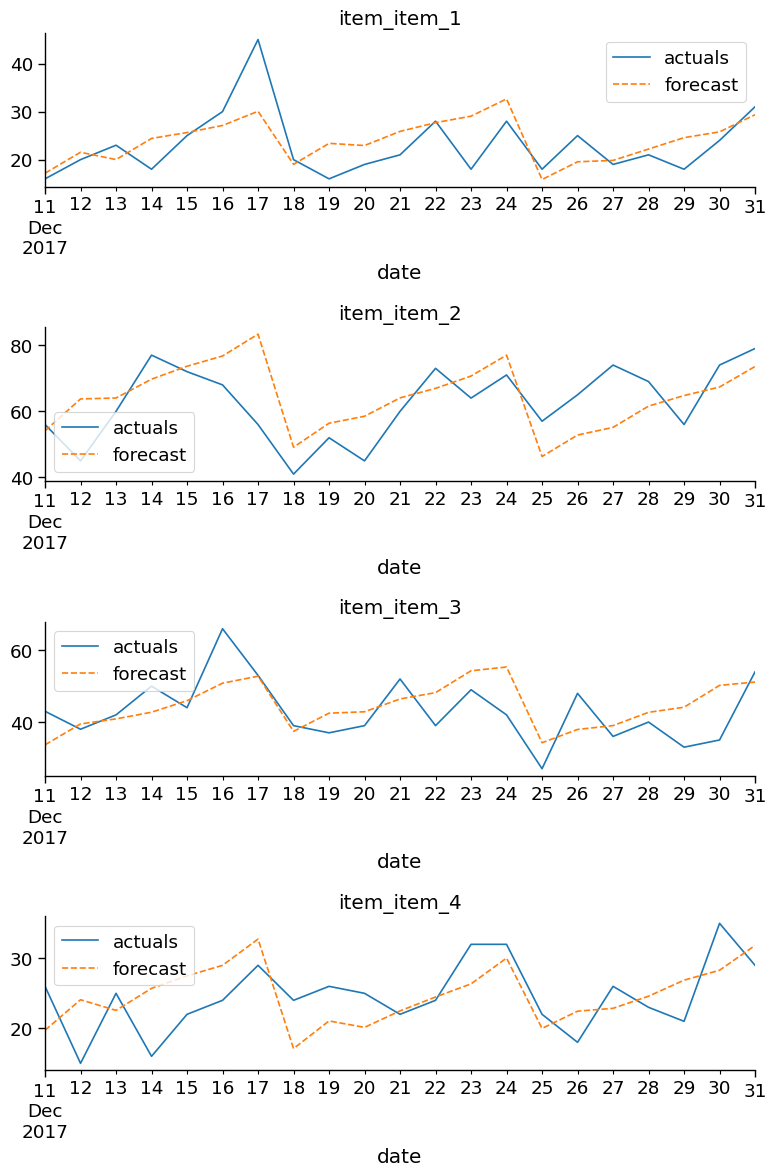

In [57]:
# Plot predictions
num_timeseries = 4
fig, axs = plt.subplots(nrows=num_timeseries, figsize=(8, 3*num_timeseries))
for i in range(4):
    timeseries = data.columns[i]
    data.iloc[-len(predictions):, i].plot(
        legend=True,
        label="actuals",
        ax=axs[i],
    )
    predictions.iloc[:, i].plot(
        legend=True,
        label="forecast",
        linestyle="--",
        ax=axs[i],
    )
    axs[i].set_title(f"{timeseries}")
    fig.tight_layout();